# MNIST手写数字识别 - PyTorch实现

## 项目介绍

在这个项目中，我们将实现一个卷积神经网络(CNN)分类模型。我们将使用经典的MNIST手写数字数据集，该数据集包含了：
- 0-9的手写数字灰度图像（28×28像素）
- 60,000个训练样本和10,000个测试样本
- 对应的数字标签（0-9）← 这是我们要预测的目标！

### 背景知识
- **MNIST数据集**：计算机视觉和机器学习领域最著名的基准数据集之一
- **卷积神经网络(CNN)**：专门用于处理图像数据的深度学习模型，能够自动提取图像特征
- **PyTorch**：由Facebook开发的流行深度学习框架，提供灵活的张量计算和神经网络构建

### 我们要做什么？
我们将构建一个CNN模型，学习识别手写数字图像，实现高精度的数字分类。


### 关键步骤概述：
1. **数据准备**：下载MNIST数据集，转换为PyTorch张量
2. **网络设计**：包含卷积层、池化层、全连接层的CNN架构
3. **训练循环**：前向传播、损失计算、反向传播、参数更新
4. **性能验证**：计算测试集准确率，可视化预测结果

这个项目将帮助你掌握使用PyTorch构建CNN模型解决实际图像分类问题的完整流程。

## <font color='red'><b>🔍 调试任务说明（可按如下提示修改第4步和第5步，其它步骤保持不变）</b></font>

<font color='red'><b>任务目标：这个项目需要完成以下核心步骤：</b></font>
<br>
<font color='red'><b>1. 数据加载与预处理：加载MNIST数据集并进行标准化处理</b></font>
<br>
<font color='red'><b>2. 模型构建：修改第4步的神经网络模型结构，设计合适的CNN网络架构</b></font>
<br>
<font color='red'><b>3. 训练优化：修改第5步模型训练超参数，训练模型</b></font>
<br>
<font color='red'><b>4. 评估测试：在测试集上评估模型性能，目标准确率达到99%以上</b></font>

评分规则说明：测试准确度在

96%-97%之间，给5分；
<br>
97%-98%之间，给10分；
<br>
98%-98.5%之间，给15分；
<br>
98.5%-99%之间，给20分；
<br>
超过99%，给25分。


## 1. 环境准备和导入库

In [1]:
# 重新安装（选择适合你环境的版本）
# 对于 CPU 版本

# 导入必要的库
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import platform

# 机器学习工具
from sklearn.model_selection import train_test_split  # 分割数据集
from sklearn.preprocessing import StandardScaler  # 数据标准化
from sklearn.metrics import classification_report  # 评估报告

# 画图工具 - 用来可视化结果
import matplotlib.pyplot as plt  
import matplotlib

# 设置中文字体显示 - 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置图像大小和分辨率
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# 在需要使用时再导入 torchvision
def get_torchvision_modules():
    from torchvision import datasets, transforms
    return datasets, transforms

# 使用时调用
datasets, transforms = get_torchvision_modules()


## 2. 检查环境和设备

In [2]:
# 打印版本信息，确保环境正确
print(f'PyTorch版本: {torch.__version__}')
print(f'Python版本: {platform.python_version()}')

# 检查是否有GPU可用，如果有就用GPU，否则用CPU
# GPU比CPU计算速度快很多，适合深度学习训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'使用设备: {device}')

if device == 'cuda':
    print(f'CUDA版本: {torch.version.cuda}')
    print(f'GPU名称: {torch.cuda.get_device_name(0)}')

PyTorch版本: 2.8.0+cu129
Python版本: 3.10.0
使用设备: cuda
CUDA版本: 12.9
GPU名称: NVIDIA RTX A4000


## 3. MNIST数据准备

MNIST数据集包含6万张手写数字图片，每张图片都是28x28像素的灰度图

### 3.1 数据预处理和加载

In [3]:
# 定义数据预处理转换
# transforms.ToTensor()：将图片转换为PyTorch张量，并自动归一化到[0,1]范围
# transforms.Normalize()：对张量进行标准化，使数据分布更均匀，有助于模型训练
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 将[0,1]范围转换为[-1,1]范围
])

# 下载并加载训练数据集
# train=True表示加载训练集，download=True表示如果本地没有就自动下载
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 下载并加载测试数据集
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f'训练集样本数: {len(train_dataset)}')
print(f'测试集样本数: {len(test_dataset)}')

训练集样本数: 60000
测试集样本数: 10000


### 3.2 创建数据加载器

In [4]:
# 创建数据加载器(DataLoader)
# DataLoader可以自动分批(batch)加载数据，并支持数据打乱(shuffle)
# batch_size=100：每批处理100张图片
# shuffle=True：每个epoch开始时打乱数据顺序
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

print(f'训练集批次数: {len(train_loader)}')
print(f'测试集批次数: {len(test_loader)}')

训练集批次数: 600
测试集批次数: 100


### 3.3 可视化数据样本

图片张量形状: torch.Size([100, 1, 28, 28])
标签形状: torch.Size([100])
显示 6 张图片


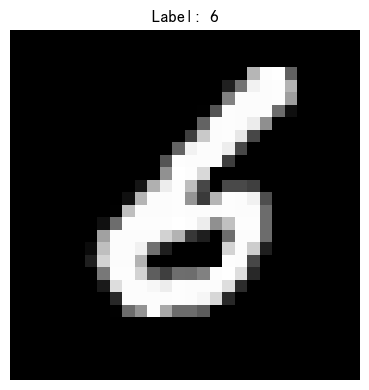

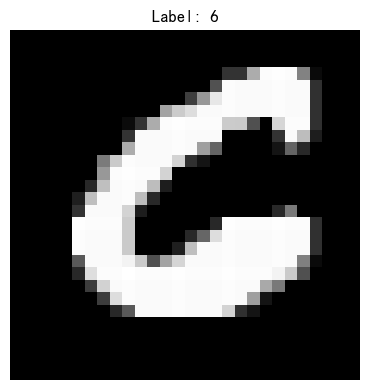

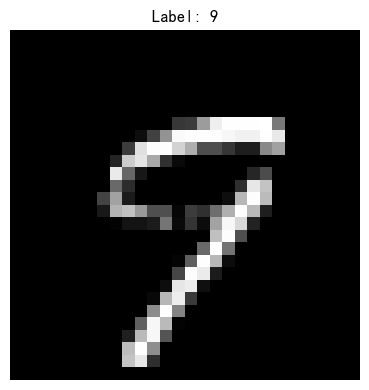

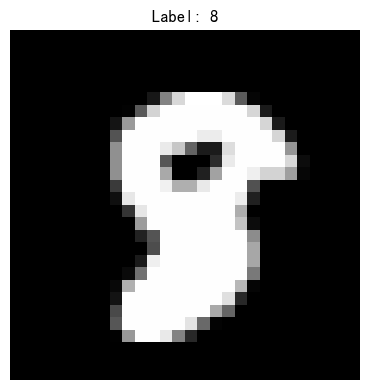

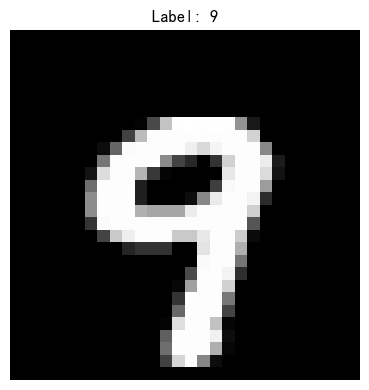

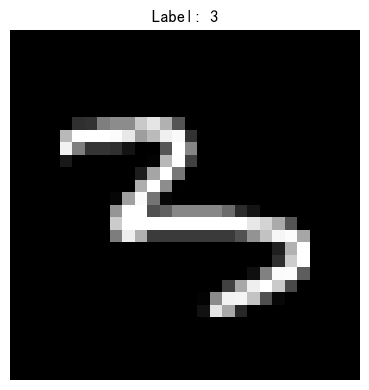

In [5]:
# 从数据加载器中获取一个批次的数据
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'图片张量形状: {images.shape}')  # [batch_size, channels, height, width]
print(f'标签形状: {labels.shape}')

import matplotlib.pyplot as plt
import torch

def simple_display(images, labels, max_display=6):
    """简化版图片显示"""
    try:
        # 确保数据在CPU上
        if images.is_cuda:
            images = images.cpu()
            labels = labels.cpu()
        
        # 分离梯度
        images = images.detach()
        labels = labels.detach()
        
        max_display = min(max_display, images.shape[0])
        print(f"显示 {max_display} 张图片")
        
        # 逐个显示，避免内存问题
        for i in range(max_display):
            plt.figure(figsize=(4, 4))
            img = images[i].squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.title(f'Label: {labels[i].item()}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"错误: {e}")

# 使用示例
data_iter = iter(train_loader)
images, labels = next(data_iter)
simple_display(images, labels)

In [19]:
class LeNet(nn.Module):

    def __init__(self):
        """初始化网络层"""
        super(LeNet, self).__init__()  # 调用父类构造函数

        # 第一个卷积层
        # 输入通道数=1(灰度图)，输出通道数=6，卷积核大小=5x5，填充=2
        # 填充(padding)是为了保持特征图尺寸不变
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)

        # 第二个卷积层
        # 输入通道数=6，输出通道数=16，卷积核大小=5x5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 全连接层
        # 16个5x5的特征图展平后是16*5*5=400个特征
        self.fc1 = nn.Linear(16*5*5, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        """前向传播过程"""

        # 第一层：卷积 -> ReLU激活 -> 最大池化
        # 输入: (batch_size, 1, 28, 28)
        # 卷积后: (batch_size, 6, 28, 28) -> 池化后: (batch_size, 6, 14, 14)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        # 第二层：卷积 -> ReLU激活 -> 最大池化
        # 输入: (batch_size, 6, 14, 14)
        # 卷积后: (batch_size, 16, 10, 10) -> 池化后: (batch_size, 16, 5, 5)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        # 展平特征图，为全连接层做准备
        # (batch_size, 16, 5, 5) -> (batch_size, 16*5*5=400)
        x = x.view(-1, 16*5*5)

        # 全连接层 + ReLU激活
        x = F.relu(self.fc1(x))

        # 输出层（不需要激活函数，因为后面会用CrossEntropyLoss）
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        """计算展平后的特征数量"""
        size = x.size()[1:]  # 获取除了batch维度之外的所有维度
        return np.prod(size)  # 计算所有维度的乘积

## 4. 构建卷积神经网络
<div style="color: #FF0000; font-size: 18px; font-weight: bold; background-color: #FFF0F0; padding: 10px; border: 2px solid #FF0000; border-radius: 5px;"> 考试任务：修改下面LeNet(nn.Module)里的网络模型配置(例如修改神经网络的层数或者增加神经元个数等)，使其测试集准确率超过99% </div>

### 4.1 查看网络结构

In [20]:
# 创建网络实例
net = LeNet()
print("网络结构:")
print(net)

# 将网络移动到设备（GPU或CPU）
net = net.to(device)
print(f"\n网络已移动到: {device}")

网络结构:
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
)

网络已移动到: cuda


### 4.2 查看网络参数

In [21]:
# 查看网络的所有可训练参数
print("网络参数:")
total_params = 0
for name, param in net.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()} (可训练参数数: {param.numel()})")
        total_params += param.numel()

print(f"\n总可训练参数数: {total_params}")

网络参数:
conv1.weight: torch.Size([6, 1, 5, 5]) (可训练参数数: 150)
conv1.bias: torch.Size([6]) (可训练参数数: 6)
conv2.weight: torch.Size([16, 6, 5, 5]) (可训练参数数: 2400)
conv2.bias: torch.Size([16]) (可训练参数数: 16)
fc1.weight: torch.Size([60, 400]) (可训练参数数: 24000)
fc1.bias: torch.Size([60]) (可训练参数数: 60)
fc2.weight: torch.Size([10, 60]) (可训练参数数: 600)
fc2.bias: torch.Size([10]) (可训练参数数: 10)

总可训练参数数: 27242


## 5. 模型训练

### 5.1 定义训练函数
<div style="color: #FF0000; font-size: 18px; font-weight: bold; background-color: #FFF0F0; padding: 10px; border: 2px solid #FF0000; border-radius: 5px;"> 考试任务：继续修改下面train_model里的模型训练参数，使其测试集准确率超过99% </div>

In [22]:
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.0005, momentum=0.9):
    """
    训练神经网络模型
    
    参数:
    - model: 要训练的神经网络模型
    - train_loader: 训练数据加载器
    - test_loader: 测试数据加载器
    - epochs: 训练轮数
    - learning_rate: 学习率
    - momentum: 动量参数
    """
    
    # 定义损失函数和优化器
    # CrossEntropyLoss: 交叉熵损失，适用于多分类问题
    # SGD: 随机梯度下降优化器，带有动量可以加速收敛
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    # 记录训练过程中的损失和准确率
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print("开始训练...")
    start_time = time.time()
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # 将数据移动到设备
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 反向传播
            loss.backward()
            
            # 参数更新
            optimizer.step()
            
            # 统计信息
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # 每100个batch打印一次信息
            if batch_idx % 100 == 99:
                print(f'[Epoch: {epoch+1}, Batch: {batch_idx+1}] 损失: {running_loss/100:.3f}')
                running_loss = 0.0
        
        # 计算训练准确率
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)
        
        # 在测试集上评估模型
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}] - 训练准确率: {train_accuracy:.2f}%, 测试准确率: {test_accuracy:.2f}%')
    
    end_time = time.time()
    print(f'训练完成! 总耗时: {end_time-start_time:.2f}秒')
    
    return train_accuracies, test_accuracies

def evaluate_model(model, test_loader):
    """评估模型在测试集上的准确率"""
    model.eval()  # 设置为评估模式
    correct = 0
    total = 0
    
    # 在评估时不需要计算梯度，可以节省内存和计算资源
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

### 5.2 开始训练

In [28]:
# 训练模型
# train_acc, test_acc = train_model(net, train_loader, test_loader, epochs=5)
# todo: LeNet模型已经足够胜任该任务，调高点学习率就够了
train_acc, test_acc = train_model(net, train_loader, test_loader, learning_rate=0.001, epochs=1, )

开始训练...
[Epoch: 1, Batch: 100] 损失: 0.002
[Epoch: 1, Batch: 200] 损失: 0.005
[Epoch: 1, Batch: 300] 损失: 0.004
[Epoch: 1, Batch: 400] 损失: 0.004
[Epoch: 1, Batch: 500] 损失: 0.003
[Epoch: 1, Batch: 600] 损失: 0.004
Epoch [1/1] - 训练准确率: 99.94%, 测试准确率: 99.24%
训练完成! 总耗时: 7.33秒


### 5.3 可视化训练过程

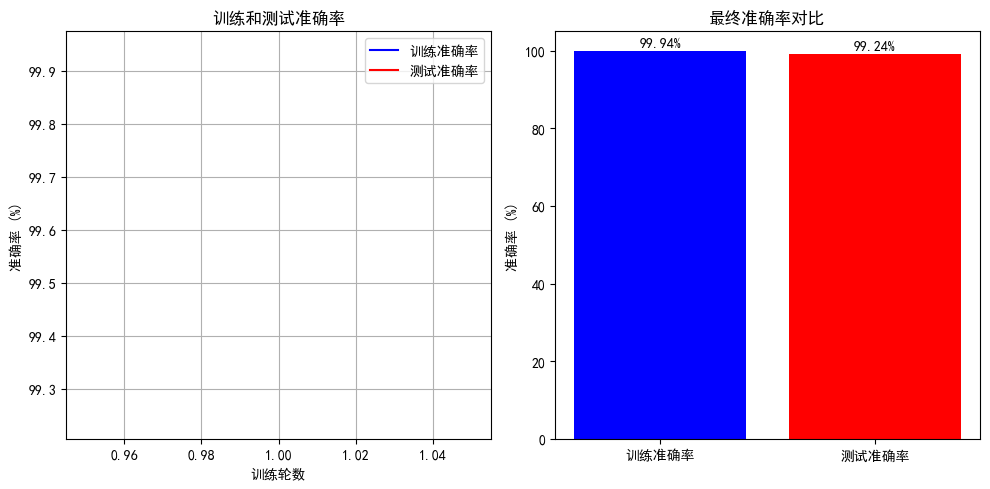

最终训练准确率: 99.94%
最终测试准确率: 99.24%


In [29]:
# 绘制训练和测试准确率曲线
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc)+1), train_acc, 'b-', label='训练准确率')
plt.plot(range(1, len(test_acc)+1), test_acc, 'r-', label='测试准确率')
plt.xlabel('训练轮数')
plt.ylabel('准确率 (%)')
plt.title('训练和测试准确率')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# 显示最终准确率
final_train_acc = train_acc[-1]
final_test_acc = test_acc[-1]
categories = ['训练准确率', '测试准确率']
values = [final_train_acc, final_test_acc]
colors = ['blue', 'red']

bars = plt.bar(categories, values, color=colors)
plt.ylabel('准确率 (%)')
plt.title('最终准确率对比')

# 在柱状图上显示数值
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"最终训练准确率: {final_train_acc:.2f}%")
print(f"最终测试准确率: {final_test_acc:.2f}%")

## 6. 模型测试和预测

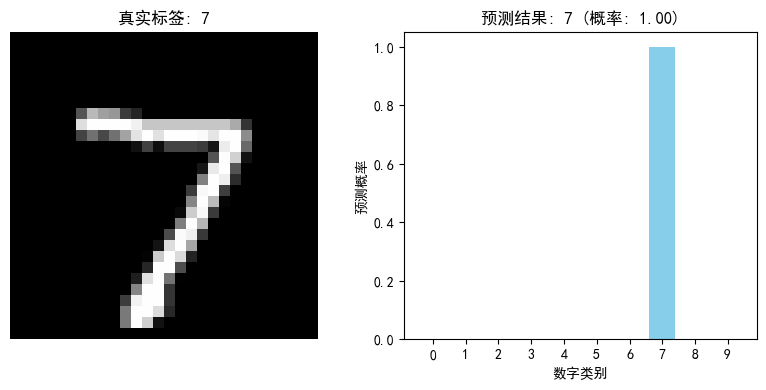

真实标签: 7
预测标签: 7
预测概率: 1.0000
✅ 预测正确!


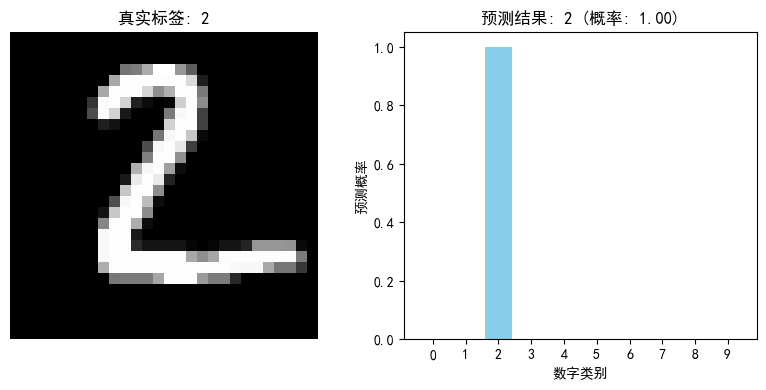

真实标签: 2
预测标签: 2
预测概率: 1.0000
✅ 预测正确!


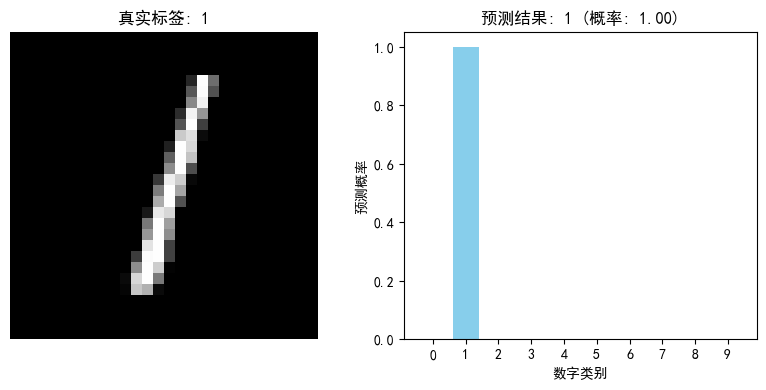

真实标签: 1
预测标签: 1
预测概率: 1.0000
✅ 预测正确!


In [30]:
def test_single_image(model, test_loader, index=0):
    """测试单张图片的预测结果"""
    model.eval()
    
    # 获取测试数据
    test_data, test_labels = next(iter(test_loader))
    
    # 选择指定索引的图片
    image = test_data[index].unsqueeze(0).to(device)  # 增加batch维度
    true_label = test_labels[index].item()
    
    # 预测
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)  # 转换为概率
        predicted_prob, predicted_label = torch.max(probabilities, 1)
    
    # 显示结果
    plt.figure(figsize=(8, 4))
    
    # 显示图片
    plt.subplot(1, 2, 1)
    img = test_data[index].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'真实标签: {true_label}')
    plt.axis('off')
    
    # 显示预测概率
    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy().flatten()
    plt.bar(range(10), probs, color='skyblue')
    plt.xlabel('数字类别')
    plt.ylabel('预测概率')
    plt.title(f'预测结果: {predicted_label.item()} (概率: {predicted_prob.item():.2f})')
    plt.xticks(range(10))
    
    plt.tight_layout()
    plt.show()
    
    print(f"真实标签: {true_label}")
    print(f"预测标签: {predicted_label.item()}")
    print(f"预测概率: {predicted_prob.item():.4f}")
    
    if true_label == predicted_label.item():
        print("✅ 预测正确!")
    else:
        print("❌ 预测错误!")

# 测试几张图片
for i in range(3):
    test_single_image(net, test_loader, index=i)

## 7. 保存和加载模型

In [31]:
# 保存训练好的模型
torch.save(net.state_dict(), 'lenet_mnist.pth')
print("模型已保存为 'lenet_mnist.pth'")

# 加载模型的示例（在实际使用时）
# 1. 创建新的网络实例
# new_net = LeNet().to(device)
# 2. 加载保存的参数
# new_net.load_state_dict(torch.load('lenet_mnist.pth'))
# 3. 设置为评估模式
# new_net.eval()

模型已保存为 'lenet_mnist.pth'


## 8. 总结

### 本教程学到的知识点:
1. **环境配置**: 检查PyTorch版本和GPU可用性
2. **数据准备**: 下载、预处理和加载MNIST数据集
3. **数据可视化**: 使用matplotlib显示图片
4. **网络构建**: 定义LeNet-5卷积神经网络
5. **模型训练**: 使用SGD优化器和交叉熵损失函数
6. **模型评估**: 计算训练和测试准确率
7. **结果可视化**: 绘制准确率曲线和预测结果
8. **模型保存**: 保存训练好的模型参数

### 进一步学习的建议:
1. 尝试调整网络结构（增加层数、改变通道数）
2. 实验不同的优化器（Adam、RMSprop等）
3. 调整超参数（学习率、批大小、训练轮数）
4. 尝试其他数据集（如Fashion-MNIST、CIFAR-10）
5. 添加正则化技术（Dropout、权重衰减）防止过拟合

In [32]:
# 最终测试准确率
final_accuracy = evaluate_model(net, test_loader)
print(f"🎉 模型在测试集上的最终准确率: {final_accuracy:.2f}%")
print("\n恭喜你完成了第一个卷积神经网络的训练! 🚀")

🎉 模型在测试集上的最终准确率: 99.24%

恭喜你完成了第一个卷积神经网络的训练! 🚀
